# Face Autoencoder Training Notebook

Use this notebook to configure, train, and analyze the face autoencoder end-to-end. It exposes the same modules the CLI used, but keeps the entire workflow inline so you can iterate interactively while artifacts are written to `projects/face_autoencoder/artifacts/`.

## 1. Environment Setup
Add the repository root to `sys.path` so we can import the reusable training modules.

In [1]:
from pathlib import Path
import sys


def find_repo_root(start: Path) -> Path:
    for path in [start] + list(start.parents):
        if (path / '.git').exists():
            return path
    return start

repo_root = find_repo_root(Path.cwd().resolve())
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))
print(f'Repo root: {repo_root}')


Repo root: /home/aghasi/repos/pa-academy-ai-2025


## 2. Imports
Bring in PyTorch, FastAI callbacks, and the project helpers (data loading, model, visualization, etc.).

In [2]:
from datetime import datetime, timezone
import json

import numpy as np
import torch
from fastai.callback.progress import CSVLogger
from fastai.callback.tracker import SaveModelCallback
from fastai.learner import Learner

from projects.face_autoencoder.src import data as data_utils
from projects.face_autoencoder.src.config import ARTIFACT_DIR, DEFAULTS
from projects.face_autoencoder.src.model import ConvVAE, VAELoss, PerceptualVAELoss, HybridVAELoss
from projects.face_autoencoder.src.training_utils import (
    reconstruction_mse,
    collect_latents,
    seed_everything,
    InlineReconstructionCallback,
)
from projects.face_autoencoder.src.visualize import (
    plot_training_curves,
    plot_latent_traversal,
    plot_reconstruction_grid,
)


## 3. Configure the run
Adjust any of these hyperparameters (latent dimension, resolution, epochs, etc.) before training.

In [ ]:
# Hyperparameters (feel free to tweak)
epochs = 200
batch_size = 256
latent_dim = 128
lr = 2e-3  # Initial learning rate
beta = 1.0
pca_components = 8
image_size = 96
lfw_resize = 1.0
seed = 42


# Loss function selection: 'mse', 'log_mse', 'perceptual', or 'hybrid'
# - 'mse': Standard MSE reconstruction loss (fast, can be blurry)
# - 'log_mse': Log(MSE) loss (often sharper than MSE, good balance)
# - 'perceptual': VGG-based perceptual loss (best quality, slower)
# - 'hybrid': Log(MSE) + Perceptual loss (recommended default - best of both)
loss_type = 'log_mse'  # Default: combines log(MSE) + perceptual loss

run_id = datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S')
run_dir = ARTIFACT_DIR / run_id
run_dir.mkdir(parents=True, exist_ok=True)
history_path = run_dir / 'history.csv'

print(f'Artifacts will be written to: {run_dir}')
print(f'Loss function: {loss_type}')


Artifacts will be written to: /home/aghasi/repos/pa-academy-ai-2025/projects/face_autoencoder/artifacts/20251130-134349
Loss function: hybrid


## 4. Build the dataloaders
This step downloads (if needed) LFW, applies resizing/normalization, and creates FastAI `DataLoaders`.

In [4]:
seed_everything(seed)
dls, info = data_utils.create_dataloaders(
    batch_size=batch_size,
    image_size=image_size,
    num_workers=DEFAULTS['num_workers'],
    seed=seed,
    lfw_resize=lfw_resize,
)
reference_batch = next(iter(dls.valid))[0]
print(f"Dataset: {info.num_samples} samples | raw size {info.height}x{info.width} | channels {info.num_channels}")


Dataset: 13233 samples | raw size 125x94 | channels 3


## 5. Create Loss Function
Select and configure the loss function based on `loss_type` parameter.

In [ ]:
# Helper function to create loss based on loss_type
def create_loss_function(loss_type: str, beta: float = 1.0):
    """Create VAE loss function based on type.
    
    Args:
        loss_type: 'mse', 'log_mse', 'perceptual', or 'hybrid'
        beta: Weight for KL divergence term
    """
    if loss_type == 'mse':
        return VAELoss(beta=beta, use_log_mse=False)
    elif loss_type == 'log_mse':
        return VAELoss(beta=beta, use_log_mse=True)
    elif loss_type == 'perceptual':
        return PerceptualVAELoss(
            beta=beta,
            perceptual_weight=1.0,
            mse_weight=0.3,  # Optional: small MSE for stability
            feature_layer='relu3_3'  # VGG layer (relu3_3 best for faces)
        )
    elif loss_type == 'hybrid':
        return HybridVAELoss(
            beta=beta,
            log_mse_weight=1.0,  # Weight for log(MSE) component
            perceptual_weight=0.1,  # Weight for perceptual component
            tv_weight=0.001,  # Weight for TV loss (reduces artifacts)
            feature_layer='relu3_3'  # VGG layer (relu3_3 best for faces)
        )
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}. Use 'mse', 'log_mse', 'perceptual', or 'hybrid'")

# Create the loss function
loss_func = create_loss_function(loss_type, beta=beta)
print(f'Created {loss_type} loss function with beta={beta}')

model = ConvVAE(
    latent_dim=latent_dim,
    image_channels=info.num_channels,
    image_size=image_size,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    metrics=[reconstruction_mse],
    path=run_dir,
    model_dir='.',
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='model'),
        CSVLogger(fname=history_path.name),
        InlineReconstructionCallback(reference_batch=reference_batch),
    ],
)
learn.to(device)
print(f'Training on device: {device}')


Created hybrid loss function with beta=1.0
Training on device: cuda


In [6]:
model

ConvVAE(
  (encoder_cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReL

## 6. Train!
Train the model with the selected learning rate scheduler. The custom callback will save per-epoch reconstructions and loss plots under the run directory.

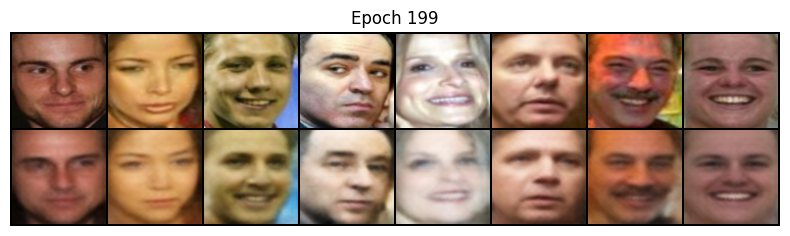

In [7]:
learn.fit_one_cycle(epochs, lr_max=lr)


## 7. Post-training analysis
Collect latent vectors, fit PCA, save metadata, and generate the final diagnostics (reconstruction grid, training curves, latent traversal).

Artifacts saved (model + PCA + metadata). Rendering diagnostics inline...


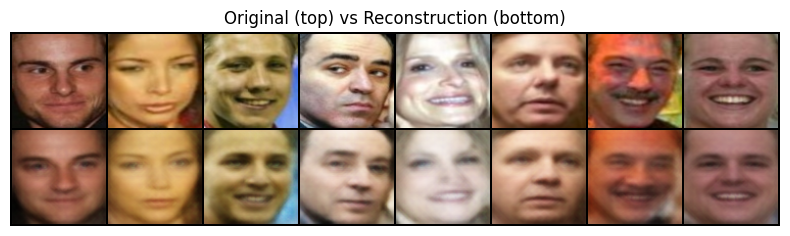

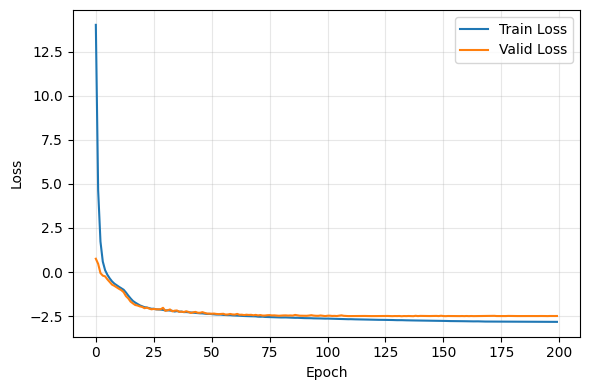

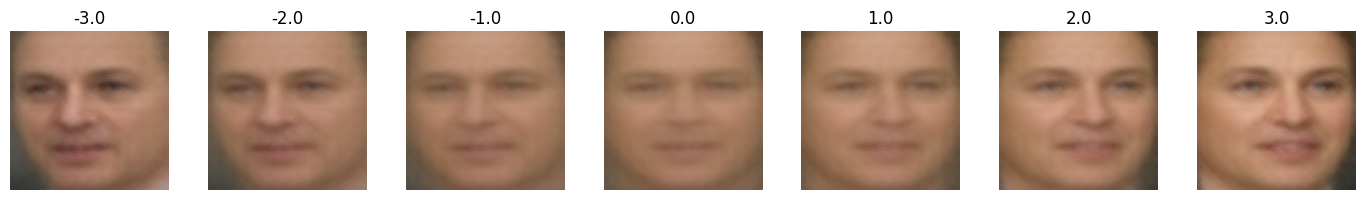

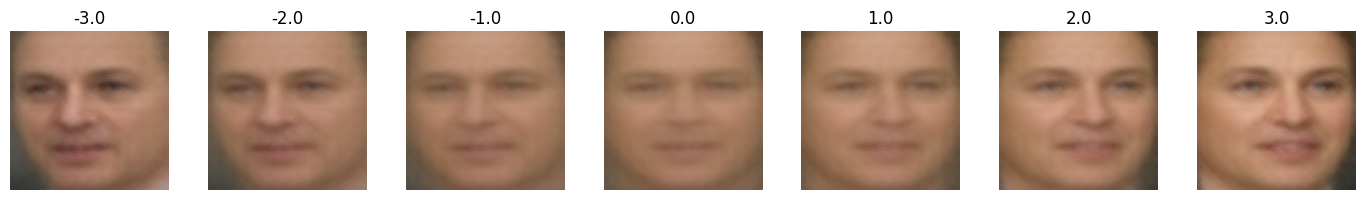

In [8]:
latents = collect_latents(learn)
latent_mean = latents.mean(axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=pca_components)
pca.fit(latents)

pca_path = run_dir / 'pca.npz'
np.savez(
    pca_path,
    components=pca.components_,
    explained_variance=pca.explained_variance_,
    explained_variance_ratio=pca.explained_variance_ratio_,
    singular_values=pca.singular_values_,
    latent_mean=latent_mean,
    pca_mean=pca.mean_,
)

metadata = {
    'run_id': run_id,
    'epochs': epochs,
    'batch_size': batch_size,
    'latent_dim': latent_dim,
    'lr': lr,
    'beta': beta,
    'loss_type': loss_type,  # Record which loss was used
    'pca_components': pca_components,
    'seed': seed,
    'image_size': image_size,
    'lfw_resize': lfw_resize,
    'run_dir': str(run_dir),
    'model_path': str(run_dir / 'model.pth'),
    'pca_path': str(pca_path),
    'log_path': str(history_path),
    'dataset': {
        'num_samples': info.num_samples,
        'height': info.height,
        'width': info.width,
    },
}
with (run_dir / 'metadata.json').open('w') as f:
    json.dump(metadata, f, indent=2)

print('Artifacts saved (model + PCA + metadata). Rendering diagnostics inline...')

plot_reconstruction_grid(
    learn.model,
    reference_batch,
    n_samples=min(8, reference_batch.size(0)),
    title='Original (top) vs Reconstruction (bottom)',
)

plot_training_curves(history_path, smoothing=1)

plot_latent_traversal(
    learn.model,
    base_latent=latent_mean,
    component=pca.components_[0],
)


## 8. Run Summary

In [9]:
from IPython.display import Markdown

Markdown(f"""
## Run Summary

- **Run ID:** `{run_id}`
- **Loss Function:** `{loss_type}`
- **Beta (KL weight):** `{beta}`
- **Epochs:** `{epochs}`
- **Latent Dim:** `{latent_dim}`
- **Image Size:** `{image_size}x{image_size}`

All artifacts live in `{run_dir}`.

### Comparing Loss Functions

To compare different loss functions, run this notebook multiple times with different `loss_type` values:
- `'mse'`: Standard MSE (fastest, can be blurry)
- `'log_mse'`: Log(MSE) (good balance, often sharper)
- `'perceptual'`: VGG perceptual loss (best quality, slower)
- `'hybrid'`: Log(MSE) + Perceptual (recommended default - combines benefits of both)

Compare the reconstruction grids and training curves to see the differences!
""")



## Run Summary

- **Run ID:** `20251130-134349`
- **Loss Function:** `hybrid`
- **Beta (KL weight):** `1.0`
- **Epochs:** `200`
- **Latent Dim:** `128`
- **Image Size:** `96x96`

All artifacts live in `/home/aghasi/repos/pa-academy-ai-2025/projects/face_autoencoder/artifacts/20251130-134349`.

### Comparing Loss Functions

To compare different loss functions, run this notebook multiple times with different `loss_type` values:
- `'mse'`: Standard MSE (fastest, can be blurry)
- `'log_mse'`: Log(MSE) (good balance, often sharper)
- `'perceptual'`: VGG perceptual loss (best quality, slower)
- `'hybrid'`: Log(MSE) + Perceptual (recommended default - combines benefits of both)

Compare the reconstruction grids and training curves to see the differences!


## Optional: Compare Multiple Loss Functions

Run the cells below to train with different loss functions and compare results side-by-side.


In [10]:
# Compare multiple loss functions
# This will train models with different losses and save results for comparison

comparison_losses = ['mse', 'log_mse', 'perceptual', 'hybrid']  # Add/remove losses to compare
comparison_results = {}

print("Training models with different loss functions for comparison...")
print("=" * 60)

for loss_name in comparison_losses:
    print(f"\nTraining with {loss_name} loss...")
    
    # Create separate run directory for each loss
    loss_run_id = f"{run_id}_{loss_name}"
    loss_run_dir = ARTIFACT_DIR / loss_run_id
    loss_run_dir.mkdir(parents=True, exist_ok=True)
    loss_history_path = loss_run_dir / 'history.csv'
    
    # Create model and loss
    loss_model = ConvVAE(
        latent_dim=latent_dim,
        image_channels=info.num_channels,
        image_size=image_size,
    )
    loss_func_comp = create_loss_function(loss_name, beta=beta)
    
    # Create learner
    learn_comp = Learner(
        dls,
        loss_model,
        loss_func=loss_func_comp,
        metrics=[reconstruction_mse],
        path=loss_run_dir,
        model_dir='.',
        cbs=[
            SaveModelCallback(monitor='valid_loss', fname='model'),
            CSVLogger(fname=loss_history_path.name),
        ],
    )
    learn_comp.to(device)
    
    # Train (use fewer epochs for comparison)
    print(f"  Training for {min(50, epochs)} epochs...")
    learn_comp.fit_one_cycle(min(50, epochs), lr_max=lr)
    
    # Collect results
    final_train_loss = learn_comp.recorder.values[-1][0]
    final_valid_loss = learn_comp.recorder.values[-1][1]
    final_recon_mse = learn_comp.recorder.values[-1][2] if len(learn_comp.recorder.values[-1]) > 2 else None
    
    comparison_results[loss_name] = {
        'train_loss': final_train_loss,
        'valid_loss': final_valid_loss,
        'recon_mse': final_recon_mse,
        'run_dir': str(loss_run_dir),
        'history_path': str(loss_history_path),
        'model': learn_comp.model,
    }
    
    print(f"  Final valid loss: {final_valid_loss:.4f}")
    if final_recon_mse:
        print(f"  Final recon MSE: {final_recon_mse:.4f}")

print("\n" + "=" * 60)
print("Comparison complete!")


Training models with different loss functions for comparison...

Training with mse loss...
  Training for 50 epochs...


epoch,train_loss,valid_loss,recon_mse,time
0,0.296618,0.205677,0.191130,00:01
1,0.194487,0.139995,0.125580,00:01
2,0.149598,0.120024,0.101895,00:01
3,0.130017,0.112895,0.097734,00:01
4,0.119251,0.110245,0.091249,00:01
5,0.112294,0.104172,0.087065,00:01
6,0.108978,0.105347,0.088025,00:01
7,0.106769,0.103195,0.084363,00:01
8,0.105122,0.103381,0.081795,00:01
9,0.105702,0.101793,0.084138,00:01


Better model found at epoch 0 with valid_loss value: 0.20567680895328522.
Better model found at epoch 1 with valid_loss value: 0.13999494910240173.
Better model found at epoch 2 with valid_loss value: 0.12002409994602203.
Better model found at epoch 3 with valid_loss value: 0.1128946989774704.
Better model found at epoch 4 with valid_loss value: 0.11024531722068787.
Better model found at epoch 5 with valid_loss value: 0.10417240113019943.
Better model found at epoch 7 with valid_loss value: 0.1031954288482666.
Better model found at epoch 9 with valid_loss value: 0.10179296135902405.
Better model found at epoch 10 with valid_loss value: 0.10077034682035446.
Better model found at epoch 11 with valid_loss value: 0.09964693337678909.
Better model found at epoch 12 with valid_loss value: 0.09882451593875885.
Better model found at epoch 13 with valid_loss value: 0.09801515191793442.
Better model found at epoch 14 with valid_loss value: 0.09712446480989456.
Better model found at epoch 15 with

epoch,train_loss,valid_loss,recon_mse,time
0,-1.201519,-1.470866,0.219761,00:01
1,-1.759469,-2.131588,0.106317,00:01
2,-2.153317,-2.493026,0.069016,00:01
3,-2.439255,-2.691844,0.053276,00:01
4,-2.649448,-2.769350,0.046039,00:01
5,-2.795442,-2.913025,0.039287,00:01
6,-2.885971,-2.864733,0.039724,00:01
7,-2.947433,-2.996219,0.034654,00:01
8,-2.995841,-2.995164,0.034959,00:01
9,-3.022267,-3.052154,0.033184,00:01


Better model found at epoch 0 with valid_loss value: -1.470866084098816.
Better model found at epoch 1 with valid_loss value: -2.1315879821777344.
Better model found at epoch 2 with valid_loss value: -2.493025779724121.
Better model found at epoch 3 with valid_loss value: -2.6918437480926514.
Better model found at epoch 4 with valid_loss value: -2.769350290298462.
Better model found at epoch 5 with valid_loss value: -2.913025140762329.
Better model found at epoch 7 with valid_loss value: -2.996218681335449.
Better model found at epoch 9 with valid_loss value: -3.0521535873413086.
Better model found at epoch 10 with valid_loss value: -3.059072732925415.
Better model found at epoch 11 with valid_loss value: -3.104910135269165.
Better model found at epoch 12 with valid_loss value: -3.1308491230010986.
Better model found at epoch 14 with valid_loss value: -3.1481921672821045.
Better model found at epoch 15 with valid_loss value: -3.176222324371338.
Better model found at epoch 17 with valid

epoch,train_loss,valid_loss,recon_mse,time
0,13.902460,12.634909,0.473541,00:05
1,12.496561,11.573473,0.426414,00:05
2,11.574428,10.733214,0.343999,00:05
3,10.821151,10.129727,0.302732,00:05
4,10.211590,9.666512,0.241387,00:05
5,9.835787,9.392766,0.220156,00:05
6,9.488621,9.174905,0.196720,00:05
7,9.244211,9.237065,0.192332,00:05
8,9.052258,8.779189,0.173870,00:05
9,8.875992,8.715522,0.167307,00:05


Better model found at epoch 0 with valid_loss value: 12.634908676147461.
Better model found at epoch 1 with valid_loss value: 11.57347297668457.
Better model found at epoch 2 with valid_loss value: 10.733214378356934.
Better model found at epoch 3 with valid_loss value: 10.129727363586426.
Better model found at epoch 4 with valid_loss value: 9.666511535644531.
Better model found at epoch 5 with valid_loss value: 9.392765998840332.
Better model found at epoch 6 with valid_loss value: 9.174904823303223.
Better model found at epoch 8 with valid_loss value: 8.779189109802246.
Better model found at epoch 9 with valid_loss value: 8.715521812438965.
Better model found at epoch 10 with valid_loss value: 8.576382637023926.
Better model found at epoch 11 with valid_loss value: 8.300708770751953.
Better model found at epoch 12 with valid_loss value: 8.217307090759277.
Better model found at epoch 13 with valid_loss value: 8.078638076782227.
Better model found at epoch 14 with valid_loss value: 7.9

epoch,train_loss,valid_loss,recon_mse,time
0,8.956113,1.405644,0.236076,00:05
1,3.041599,0.307168,0.228231,00:05
2,1.287992,0.119857,0.217722,00:05
3,0.433817,-0.221894,0.194676,00:05
4,-0.112772,-0.621190,0.138473,00:05
5,-0.364561,-0.523153,0.135375,00:05
6,-0.585545,-0.901391,0.105472,00:05
7,-0.812712,-1.148518,0.076058,00:05
8,-1.135026,-1.426032,0.058022,00:05
9,-1.385348,-1.659268,0.047979,00:05


Better model found at epoch 0 with valid_loss value: 1.4056442975997925.
Better model found at epoch 1 with valid_loss value: 0.30716782808303833.
Better model found at epoch 2 with valid_loss value: 0.11985719949007034.
Better model found at epoch 3 with valid_loss value: -0.22189444303512573.
Better model found at epoch 4 with valid_loss value: -0.6211904883384705.
Better model found at epoch 6 with valid_loss value: -0.9013906121253967.
Better model found at epoch 7 with valid_loss value: -1.1485178470611572.
Better model found at epoch 8 with valid_loss value: -1.4260317087173462.
Better model found at epoch 9 with valid_loss value: -1.6592680215835571.
Better model found at epoch 10 with valid_loss value: -1.771787166595459.
Better model found at epoch 11 with valid_loss value: -1.888659119606018.
Better model found at epoch 12 with valid_loss value: -1.932204008102417.
Better model found at epoch 13 with valid_loss value: -1.959945797920227.
Better model found at epoch 14 with va

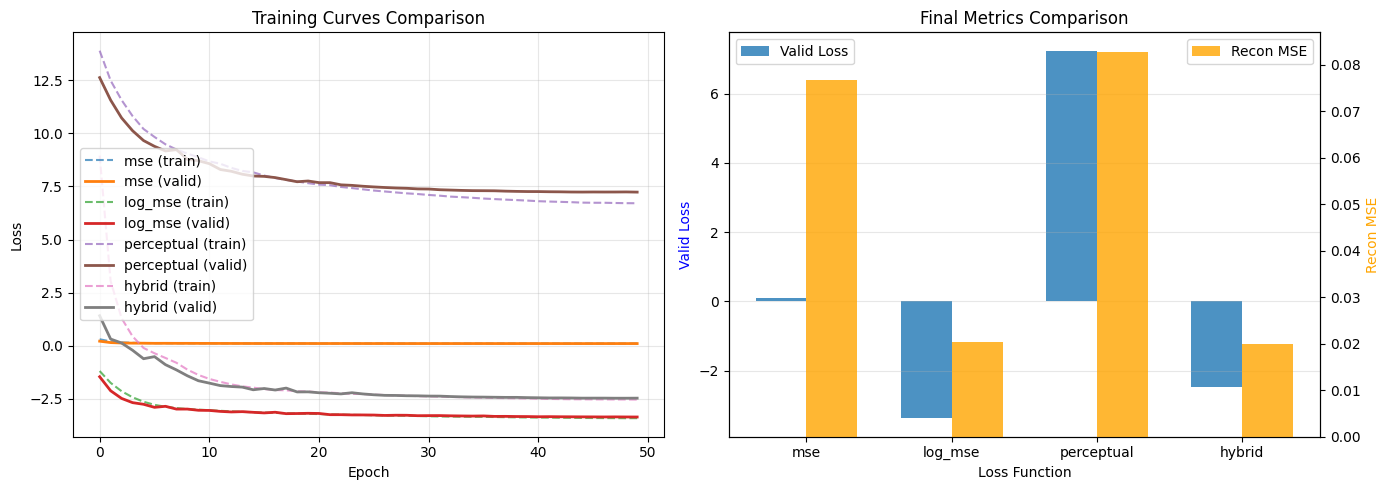


Comparison Summary:
------------------------------------------------------------
Loss Function   Valid Loss   Recon MSE   
------------------------------------------------------------
mse             0.0936       0.0768      
log_mse         -3.3688      0.0204      
perceptual      7.2349       0.0829      
hybrid          -2.4807      0.0200      
------------------------------------------------------------


In [11]:
# Visualize comparison results
import pandas as pd
import matplotlib.pyplot as plt

# Plot training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training curves
ax1 = axes[0]
for loss_name, results in comparison_results.items():
    if results['history_path']:
        df = pd.read_csv(results['history_path'])
        ax1.plot(df['epoch'], df['train_loss'], label=f'{loss_name} (train)', linestyle='--', alpha=0.7)
        ax1.plot(df['epoch'], df['valid_loss'], label=f'{loss_name} (valid)', linewidth=2)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Curves Comparison')
ax1.legend()
ax1.grid(alpha=0.3)

# Final metrics comparison
ax2 = axes[1]
loss_names = list(comparison_results.keys())
valid_losses = [comparison_results[n]['valid_loss'] for n in loss_names]
recon_mses = [comparison_results[n]['recon_mse'] for n in loss_names if comparison_results[n]['recon_mse']]

x = np.arange(len(loss_names))
width = 0.35

ax2_twin = ax2.twinx()
bars1 = ax2.bar(x - width/2, valid_losses, width, label='Valid Loss', alpha=0.8)
if recon_mses:
    bars2 = ax2_twin.bar(x + width/2, recon_mses, width, label='Recon MSE', alpha=0.8, color='orange')

ax2.set_xlabel('Loss Function')
ax2.set_ylabel('Valid Loss', color='blue')
ax2_twin.set_ylabel('Recon MSE', color='orange')
ax2.set_title('Final Metrics Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(loss_names)
ax2.legend(loc='upper left')
if recon_mses:
    ax2_twin.legend(loc='upper right')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary table
print("\nComparison Summary:")
print("-" * 60)
print(f"{'Loss Function':<15} {'Valid Loss':<12} {'Recon MSE':<12}")
print("-" * 60)
for loss_name, results in comparison_results.items():
    recon_mse_str = f"{results['recon_mse']:.4f}" if results['recon_mse'] else "N/A"
    print(f"{loss_name:<15} {results['valid_loss']:<12.4f} {recon_mse_str:<12}")
print("-" * 60)


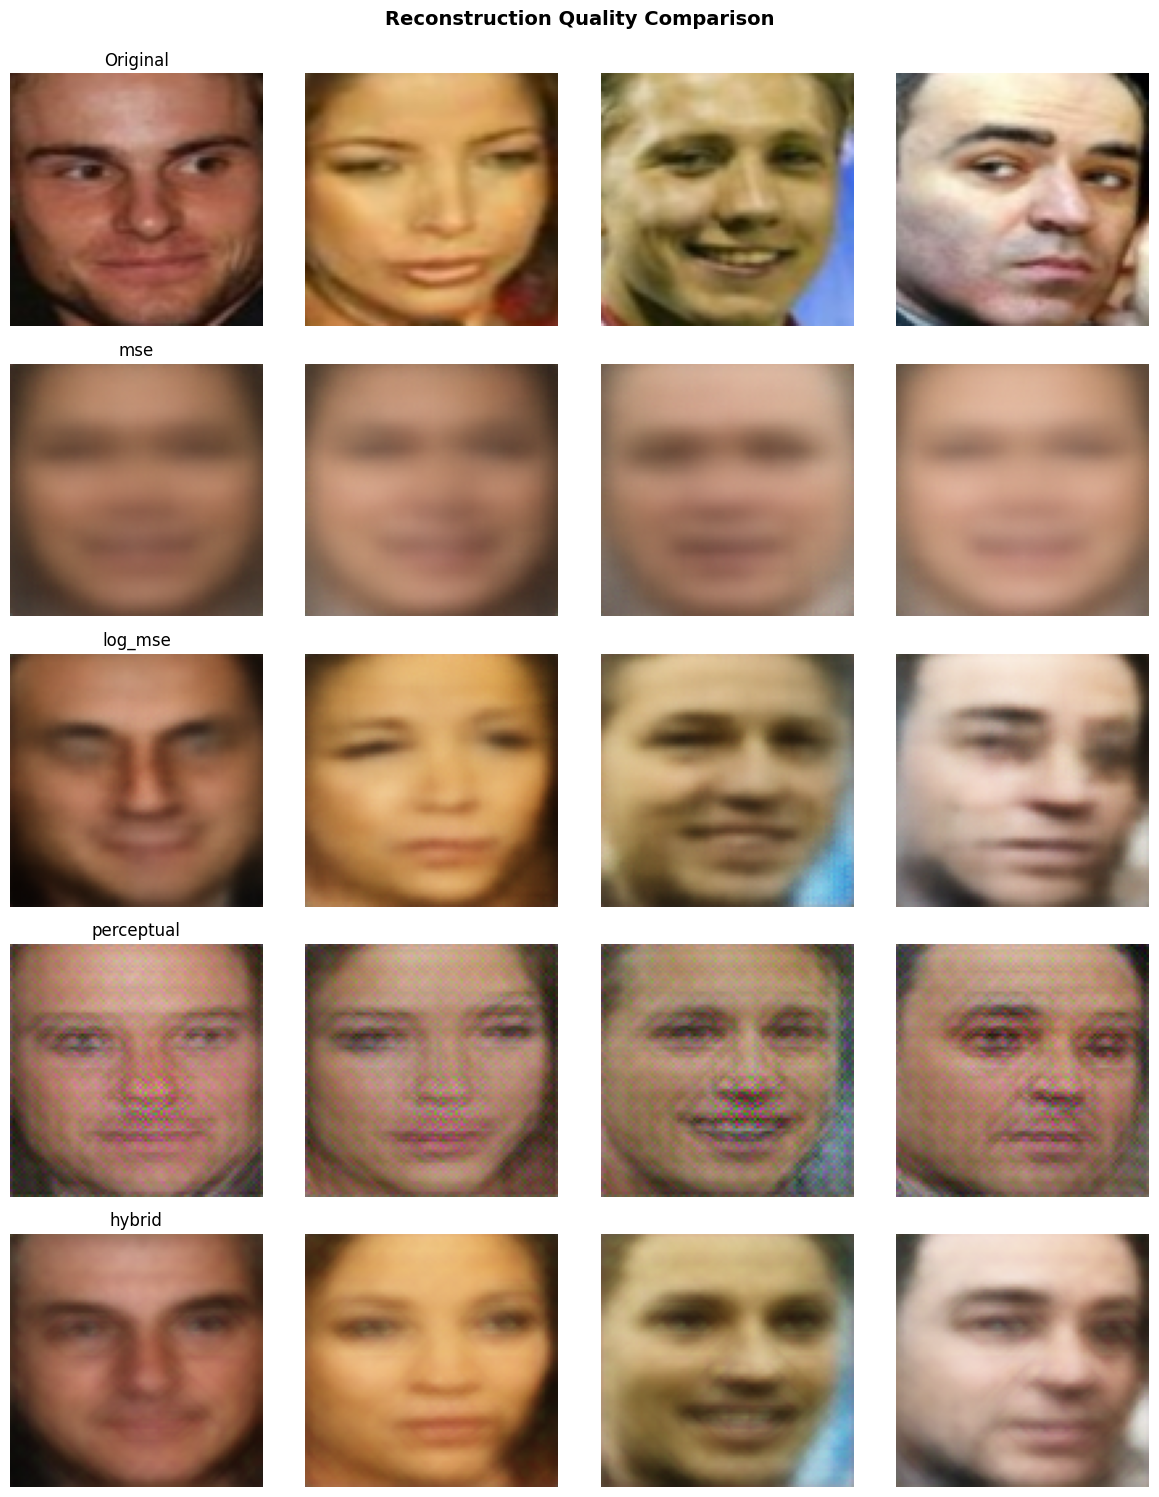

In [15]:
# Visualize reconstruction quality comparison
n_samples = min(4, reference_batch.size(0))
fig, axes = plt.subplots(len(comparison_losses) + 1, n_samples, figsize=(n_samples * 3, (len(comparison_losses) + 1) * 3))

# Show originals in first row
for i in range(n_samples):
    axes[0, i].imshow(data_utils.denormalize(reference_batch[i]).permute(1, 2, 0).cpu().numpy())
    axes[0, i].set_title('Original' if i == 0 else '')
    axes[0, i].axis('off')

# Show reconstructions for each loss
for row, loss_name in enumerate(comparison_losses, start=1):
    model_comp = comparison_results[loss_name]['model']
    model_comp.eval()
    with torch.no_grad():
        outputs = model_comp(reference_batch[:n_samples].to(device))
        reconstructions = outputs.reconstruction.cpu()
    
    for col in range(n_samples):
        recon_img = data_utils.denormalize(reconstructions[col]).permute(1, 2, 0).numpy()
        axes[row, 0].set_title(loss_name)

        axes[row, col].imshow(recon_img)
        if col == 0:
            axes[row, col].set_ylabel(loss_name, rotation=0, labelpad=20, fontsize=12, fontweight='bold')
        axes[row, col].axis('off')

plt.suptitle('Reconstruction Quality Comparison', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
